In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 33.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=0e3805076b60212411587bad011eb5e405e827e8baece67fb82e9261a36c6e4a
  Stored in directory: /home/liuxr/.cache/pip/wheels/aa/16/a8/fd7737d723cc1eb8df023c016c262ff4520091e1b022f8c164
Successfully built torch_geometric


In [20]:
!export OMP_NUM_THREADS=8

In [1]:
from torch_geometric.datasets import QM9
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import logging
import time

import os.path as osp

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import GRU, Linear, ReLU, Sequential
import torch.optim as optim

import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set, MessagePassing, global_mean_pool, aggr
from torch_geometric.utils import remove_self_loops

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

C:\Users\liuxr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Each model and target combination was trained using a uniform random hyper parameter search with 50 trials. 

T was costrained to be in the range 3 ≤ T ≤ 8 (in practice, any T ≥ 3 works). 

The number of set2set computations M was chosen from the range 1 ≤ M ≤ 12. 

All models were trained using SGD with the ADAM optimizer (Kingma &Ba (2014)), with batch size 20 for 3 million steps ( 540 epochs). 

The initial learning rate was chosen uniformly between 1e−5 and 5e−4. We used a linear learning rate decay that began between 10% and 90% of the way through training and the initial learning rate l decayed to a final learning ate l ∗ F, using a decay factor F in the range [.01, 1].

The QM-9 dataset has 130462 molecules in it. We randomly chose 10000 samples for validation, 10000 samples or testing, and used the rest for training. We use the validation set to do early stopping and model selection and we eport scores on the test set. 

All targets were normalized o have mean 0 and variance 1. We minimize the mean quared error between the model output and the target, although we evaluate mean absolute error.

In [2]:
qm9 = QM9('./datasets/QM9')

Extracting datasets\QM9\raw\qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [3]:
qm9

QM9(130831)

In [4]:
qm9[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [5]:
qm9[1]

Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_2', z=[4])

In [6]:
dataset = qm9
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of classes aka. molecule properties: {dataset.num_classes}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of node features: 11
Number of classes aka. molecule properties: 19


In [7]:
data = dataset[0]
# 11 node features
data.x

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [8]:
# 19 classes aka molecule properties
data.y

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

In [9]:
print(data)
print(data.edge_index)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [10]:
data.y[:, 2]

tensor([-10.5499])

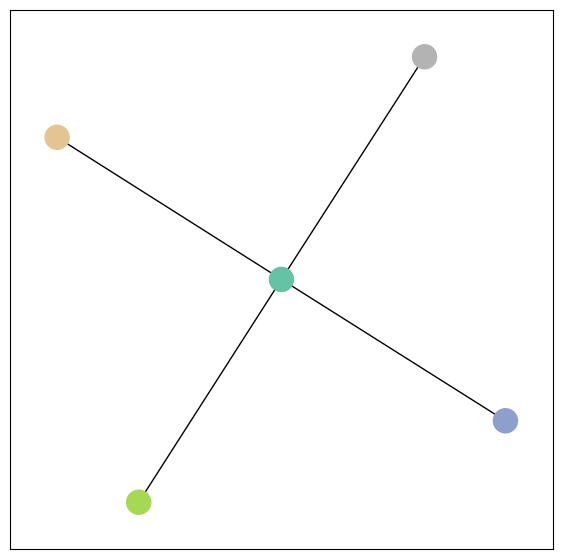

In [11]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=[1,2,3,4,5])

In [2]:
target = 0 # the first property is the one to be predicted

class TargetTransform:
    def __call__(self, data):
        # Specify target.
        data.y = data.y[:, target]
        return data

path = './datasets/QM9'
transform = T.Compose([TargetTransform(), T.Distance(norm=False)]) # add the distance into edge attributes
dataset = QM9(path, transform=transform)

In [20]:
data = dataset[0]
print('After transformation:')
print(data)
print(data.edge_index)
print(data.edge_attr)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

After transformation:
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 5], y=[1], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919]])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### General statistics analysis

check what undirected means in their method

Node features:

Atom type H, C, N, O, F (one-hot)

Atomic number Number of protons (integer)

Acceptor Accepts electrons (binary)

Donor Donates electrons (binary)

Aromatic In an aromatic system (binary)

Hybridization sp, sp2, sp3 (one-hot or null)

Number of Hydrogens (integer)

In [14]:
# Calculate the average size of a molecule graph
total_nodes = 0
total_graphs = len(dataset)

for data in dataset:
    total_nodes += data.num_nodes

average_size = total_nodes / total_graphs

# Find the minimum and maximum number of nodes in one graph
min_nodes = float('inf')
max_nodes = 0

for data in dataset:
    num_nodes = data.num_nodes
    min_nodes = min(min_nodes, num_nodes)
    max_nodes = max(max_nodes, num_nodes)

# Print the results
print(f"Average size of a molecule graph: {average_size:.2f} nodes")
print(f"Minimum number of nodes in one graph: {min_nodes} nodes")
print(f"Maximum number of nodes in one graph: {max_nodes} nodes")

Average size of a molecule graph: 18.03 nodes
Minimum number of nodes in one graph: 3 nodes
Maximum number of nodes in one graph: 29 nodes


In [18]:
# Count the occurrences of each atom type
atom_counts = Counter()

for data in dataset:
    atom_types = data.x[:, :5].argmax(dim=1).tolist()
    atom_counts.update(atom_types)

# Define the atom labels
atom_labels = {0: 'H', 1: 'C', 2: 'O', 3: 'N', 4: 'F'}

# Print the results
print("Number of occurrences for each atom:")
for atom_type, count in atom_counts.items():
    atom_label = atom_labels[atom_type]
    print(f"{atom_label}: {count} occurrences")

Number of occurrences for each atom:
C: 831925 occurrences
H: 1208486 occurrences
O: 132498 occurrences
N: 183265 occurrences
F: 3036 occurrences


In [19]:
# Calculate average edge distance and average edge number
total_distance = 0
total_edges = 0

# Calculate the distribution of different bond types
bond_counts = Counter()

for data in dataset:
    total_distance += data.edge_attr[:, 4].sum()
    total_edges += data.edge_index.size(1)

    bond_types = np.unique(data.edge_attr[:, :4], axis=0)
    bond_counts.update([tuple(bond) for bond in bond_types])

average_distance = total_distance / total_edges
average_edges = total_edges / len(dataset)

total_bonds = sum(bond_counts.values())
bond_distribution = {bond_type: count / total_bonds for bond_type, count in bond_counts.items()}

# Print the results
print(f"Average edge distance: {average_distance:.2f} Angstrom")
print(f"Average number of edges: {average_edges:.2f}")
print("Distribution of different bond types:")
for bond_type, percentage in bond_distribution.items():
    print(f"Bond Type {bond_type}: {percentage * 100:.2f}%")

Average edge distance: 1.27 Angstrom
Average number of edges: 37.33
Distribution of different bond types:
Bond Type (1.0, 0.0, 0.0, 0.0): 54.71%
Bond Type (0.0, 0.0, 1.0, 0.0): 13.41%
Bond Type (0.0, 1.0, 0.0, 0.0): 31.88%


In [3]:
model_name = 'b20_e100_r001_adam_mse_nnconvMean_poolMaxAggr_2fc'
config = {
    "in_channels": dataset.num_features,
    "out_channels": 1,
    "hidden_dim_1": 64,
    "hidden_dim_2": 128,
    "hidden_dim_3": 32,
    "lr": 0.001,
    "batch_size": 20,
    "num_epochs": 100,
    "processing_steps": 10, #for set2set
    "criterion": nn.MSELoss(),
    "nnconv_aggr": 'mean',
    }

In [4]:
logging.basicConfig(filename = model_name+'.log',
                    level = logging.INFO,
                    format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')
 
logging.info(config)

In [5]:
# Split datasets.
torch.manual_seed(12345)
dataset = dataset.shuffle()
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
train_dataset = dataset[20000:]
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False) #10000
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False) #10000
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True) #110831

In [6]:
train_dataset[0]

Data(x=[13, 11], edge_index=[2, 28], edge_attr=[28, 5], y=[1], pos=[13, 3], idx=[1], name='gdb_49057', z=[13])

By defining the message() and update() functions, you control how information is propagated through the graph and how nodes update their representations based on the received messages. These functions enable the GNN to learn from the graph structure and capture useful information for the prediction task.

During the forward() pass, the GNN iteratively performs message passing and aggregation steps across the graph, combining information from neighboring nodes to update each node's representation. The output of the forward() function provides the final representations that can be further processed or used for downstream tasks.

In [29]:
# Define the GNN model with customized message passing layer
class GNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__(aggr='mean')
        #super(GNN, self).__init__(aggr=aggr.SoftmaxAggregation(learn=True))
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index,edge_attr, x=x)

    def message(self, x_j, edge_attr):
        #print(x_j)
        #print(x_j.shape)
        return self.lin(x_j)
    # It takes x_j as input, which represents the feature representations of the neighboring nodes.
    # num_edges * node_features

    def update(self, aggr_out):
        return aggr_out


# Define the GNN-based model
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_dim_1, hidden_dim_2, hidden_dim_3, out_channels):
        super(GNNModel, self).__init__()
        self.gnn = GNN(in_channels, hidden_dim_1)
        # Use a global sort aggregation:
        self.global_pool = aggr.MeanAggregation()
        #self.global_pool = aggr.Set2Set(hidden_dim_1, processing_steps) # output of this layer is 2*dimensionality of input
        self.fc1 = nn.Linear(hidden_dim_1, hidden_dim_3)
        self.fc2 = nn.Linear(hidden_dim_3, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gnn(x, edge_index, edge_attr).relu()
        #x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.global_pool(x,batch)
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

In [7]:
# Define the GNN model
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_dim_1, hidden_dim_2, hidden_dim_3, out_channels):
        super(GNNModel, self).__init__()
        #nn – A neural network that maps edge features edge_attr of shape [-1, num_edge_features] to shape [-1, in_channels * out_channels], e.g., defined by torch.nn.Sequential.
        nn1 = nn.Sequential(nn.Linear(5, 128), ReLU(), nn.Linear(128, in_channels * hidden_dim_1)) # maps to in_channels * out_channels
        self.conv1 = NNConv(in_channels, hidden_dim_1, nn1, aggr=config["nnconv_aggr"]) #11*64
        self.global_pool = aggr.MaxAggregation()
        self.fc1 = nn.Linear(hidden_dim_1, hidden_dim_3)
        self.fc2 = nn.Linear(hidden_dim_3, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index, edge_attr).relu()
        #x = global_mean_pool(x, batch)  # size = [batch_size, hidden_channels]
        x = self.global_pool(x,batch)
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

In [8]:
# Initialize the model, optimizer, and loss function
model = GNNModel(config["in_channels"], config["hidden_dim_1"], config["hidden_dim_2"], config["hidden_dim_3"], config["out_channels"])
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
print(model)
logging.info(model)

GNNModel(
  (conv1): NNConv(11, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=704, bias=True)
  ))
  (global_pool): MaxAggregation()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test before training
model.eval()
total_test_loss = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data).flatten()
        test_loss = config["criterion"](output, data.y)
        total_test_loss += test_loss.item() * data.num_graphs

average_test_loss_before = total_test_loss / len(test_loader.dataset)
print(f'Test Loss before training: {average_test_loss_before:.4f}')
logging.info(f'Test Loss before training: {average_test_loss_before:.4f}')

t0 = time.time()
# Training loop
model.to(device)
model.train()

min_valid_loss = np.inf
loss_values = []
val_loss_values = []

for epoch in range(config["num_epochs"]):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch).flatten()
        loss = config["criterion"](output, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    average_loss = total_loss  / len(train_loader.dataset)
    loss_values.append(average_loss)
    print(f'Epoch: {epoch}, Training Loss: {average_loss:.4f}')
    logging.info(f'Epoch: {epoch}, Training Loss: {average_loss:.4f}')
    
    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data).flatten()
            val_loss = config["criterion"](output, data.y)
            total_val_loss += val_loss.item() * data.num_graphs

    average_val_loss = total_val_loss / len(val_loader.dataset)
    val_loss_values.append(average_val_loss)
    print(f'Epoch: {epoch}, Validation Loss: {average_val_loss:.4f}')
    logging.info(f'Epoch: {epoch}, Validation Loss: {average_val_loss:.4f}')
    
    # Update model if validation improved
    if min_valid_loss > average_val_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.4f} ---> {average_val_loss:.4f}) \t Saving The Model')
        min_valid_loss = average_val_loss
        # Saving State Dict
        config["model_state"] = model.state_dict()
        FILE_path = "model_"+model_name+".pth"
        torch.save(config, FILE_path)

print(f'Training time: {time.time()-t0}')
logging.info(f'Training time: {time.time()-t0}')

Test Loss before training: 8.4049
Epoch: 0, Training Loss: 1.2380
Epoch: 0, Validation Loss: 1.1916
Validation Loss Decreased(inf ---> 1.1916) 	 Saving The Model
Epoch: 1, Training Loss: 1.1136
Epoch: 1, Validation Loss: 1.0425
Validation Loss Decreased(1.1916 ---> 1.0425) 	 Saving The Model
Epoch: 2, Training Loss: 0.9909
Epoch: 2, Validation Loss: 0.9971
Validation Loss Decreased(1.0425 ---> 0.9971) 	 Saving The Model
Epoch: 3, Training Loss: 0.9532
Epoch: 3, Validation Loss: 0.9106
Validation Loss Decreased(0.9971 ---> 0.9106) 	 Saving The Model
Epoch: 4, Training Loss: 0.9259
Epoch: 4, Validation Loss: 0.9253
Epoch: 5, Training Loss: 0.9058
Epoch: 5, Validation Loss: 0.8836
Validation Loss Decreased(0.9106 ---> 0.8836) 	 Saving The Model
Epoch: 6, Training Loss: 0.8856
Epoch: 6, Validation Loss: 0.9133
Epoch: 7, Training Loss: 0.8730
Epoch: 7, Validation Loss: 0.8624
Validation Loss Decreased(0.8836 ---> 0.8624) 	 Saving The Model
Epoch: 8, Training Loss: 0.8628
Epoch: 8, Validatio

Epoch: 97, Validation Loss: 0.7179
Epoch: 98, Training Loss: 0.6923
Epoch: 98, Validation Loss: 0.7067
Epoch: 99, Training Loss: 0.6915
Epoch: 99, Validation Loss: 0.7082
Training time: 10378.600487232208


In [10]:
# Test after training
model.eval()
total_test_loss = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data).flatten()
        test_loss = config["criterion"](output, data.y)
        total_test_loss += test_loss.item() * data.num_graphs

average_test_loss = total_test_loss / len(test_loader.dataset)
print(f'Test Loss before training: {average_test_loss_before:.4f}')
print(f'Test Loss after training: {average_test_loss:.4f}')
logging.info(f'Test Loss before training: {average_test_loss_before:.4f}')
logging.info(f'Test Loss after training: {average_test_loss:.4f}')

Test Loss before training: 8.4049
Test Loss after training: 0.6803


In [11]:
np.savetxt('./loss_values/loss_values_'+model_name+'.txt',loss_values)
np.savetxt('./loss_values/val_loss_values_'+model_name+'.txt',val_loss_values)

In [ ]:
np.savetxt('./loss_values/loss_values_b20_e100_r001_adam_CE_nnconvMean_poolMeanAggr_2fc.txt',loss_values)
np.savetxt('./loss_values/val_loss_values_b20_e100_r001_adam_CE_nnconvMean_poolMeanAggr_2fc.txt',val_loss_values)

In [12]:
loss_values = np.loadtxt("./loss_values/loss_values_"+model_name+".txt")
valid_loss_values = np.loadtxt("./loss_values/val_loss_values_"+model_name+".txt")

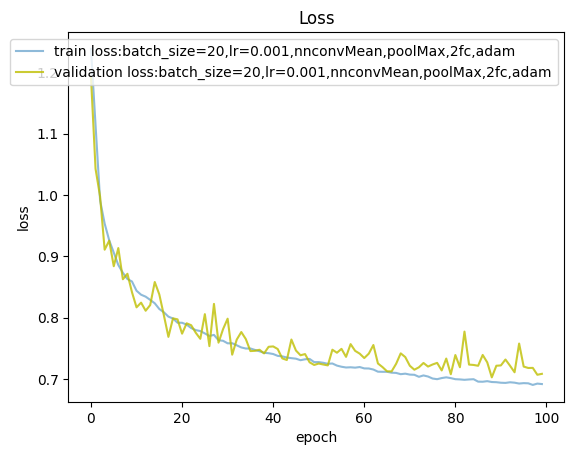

In [13]:
plt.plot(loss_values, label='train loss:batch_size=20,lr=0.001,nnconvMean,poolMax,2fc,adam', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values,'y', label='validation loss:batch_size=20,lr=0.001,nnconvMean,poolMax,2fc,adam', ls='-', ms=20, markevery=100, alpha=0.8)

#don't know why the markevery doesn't work
plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.title("Loss")
plt.legend()
plt.show()

In [29]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(11, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)
